# Necessary parameters

In [1]:
# The name of the directory containing the scans. Currently allowed image formats for the 
# scans are jpeg, tiff and png.
dirname = r"/home/mkoerschens/datasets/Scans/Franzi/mini" 

# The DPI of the scans
dpi = 600

# The path where the result table will be saved. Should be a .csv file
save_path = r"test_table2.csv"

# Optional parameters

In [2]:
# Before processing the image, parts of the border are cropped to prevent objects being detected
# at the image borders, which are usually irregular. This value designates the percentage 
# to be cropped on each side. A value of 0.02 removes 2% of the image from the top, bottom, 
# left and right of the image
# Default: 0.02
border_crop_relative = 0.02

# This value designates, how strongly neighboring pixels may differ to still be considered background during the
# initial segmentation. Higher values include more 'shadowy' pixels in the background, but may also include 
# parts of the plants. The default values 0.01 should work for most cases, but feel free to change the values,
# if too little shadow or bigger parts of the plants are designated as background. 
# Default: 0.01
floodfill_tolerance = 0.02 #35 #0.0115

# The image is being resized to increase processing speed at the cost of exactness of the result of the area.
# This value designates, to how many pixels the longer side of the image should be rescaled 
# while keeping the aspect ratio of the image.
# The default value 1024 should be a good trade-off between speed and accuracy and should work well for most cases,
# while keeping the exactness error negligible. Try out different values at your own risk.
# Default: 1024
image_size_bigger_side = 1024

# This value is a threshold, determining if an component is too small to be kept in the segmentation. 
# It is a value relative to the size of the complete image, i.e. if the value is 0.1 all object with a size
# smaller than 10% of the image are being removed.
small_component_erase_percentage_threshold = 2e-4

# Imports

In [3]:
import re
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from scipy.ndimage import label

# Function definitions

## Floodfill

In [4]:
def floodfill_segmentation(image, starting_pixel=None, tolerance=0.04, verbose=False):    
    def pixel_average(image, pixel):
        return np.mean(image[pixel[1], pixel[0], :])
    
    if starting_pixel is None: # Retrieve corner pixel with maximal pixel average as starting point 
        possible_pixels = [(0, 0), (image.shape[1] - 1, 0), (0, image.shape[0] - 1), (image.shape[1] - 1, image.shape[0] - 1)]
        
        max_pixel = None
        
        for pixel in possible_pixels:
            if max_pixel is None or pixel_average(image, pixel) > pixel_average(image, max_pixel):
                max_pixel = pixel   
            
        starting_pixel = max_pixel
    
    pixels_visited_or_queued = set()
    next_pixels = [starting_pixel]  # FILO queue

    neighbor_indices = [
        np.array((0, -1)),
        np.array((0, 1)),
        np.array((1, 0)),
        np.array((-1, 0)),
    ]

    segmentation_map = np.ones_like(image[:, :, 0])

    pixel_count = 0
    
    last_text = ""

    while next_pixels:
        pixel_count += 1

        if pixel_count % 10000 == 0 and verbose:
            print("\b" * len(last_text), end="\r")
            last_text = "Pixel {}/{} ({}%)".format(pixel_count, np.prod(image.shape[:2]), int(pixel_count / np.prod(image.shape[:2]) * 100))
            print(last_text, end="")

        current_pixel = next_pixels.pop()

        pixels_visited_or_queued.add(current_pixel)

        current_pixel = np.array(current_pixel)

        segmentation_map[current_pixel[1], current_pixel[0]] = 0

        # Get mean pixel value
        avg_val = pixel_average(image, current_pixel)

        # Iterate neighboring pixels
        for n_index in neighbor_indices:
            next_pixel = tuple(current_pixel + n_index)

            #print(max_difference(image, current_pixel, next_pixel))

            if next_pixel not in pixels_visited_or_queued and \
               0 <= next_pixel[0] < image.shape[1] and \
               0 <= next_pixel[1] < image.shape[0] and \
               np.abs(avg_val - pixel_average(image, next_pixel)) < tolerance * 255: # * (0.75 * avg_val / 255.0 + 0.25):

                next_pixels.append(next_pixel)
                pixels_visited_or_queued.add(next_pixel)

    return segmentation_map

## Get component indices

In [5]:
def get_component_indices(segmentation_map):
    structure = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])

    labeled, ncomponents = label(segmentation_map, structure)

    indices = np.indices(segmentation_map.shape).T[:, :, [1, 0]]
    indices = np.swapaxes(indices, 0, 1)
    
    component_indices_list = []

    for component_number in range(ncomponents):
        component_indices = indices[labeled == (component_number + 1)]
        
        component_indices_list.append(component_indices)
    
    return component_indices_list

## Segmentation helper functions

In [6]:
def erase_small_components(segmentation_map, min_image_percentage=1e-4):
    component_indices = get_component_indices(segmentation_map)
    
    nr_erased = 0
    n_components = 0
    
    min_size = np.prod(segmentation_map.shape[:2]) * min_image_percentage
    
    for component in component_indices:
        # Test, if component is too small
        if len(component) < min_size:
            nr_erased += 1
            
            for idx in component:
                segmentation_map[idx[1], idx[0]] = 0
        else:
            print(f"Found component with {len(component)} pixels")
            n_components += 1
                
    print(f"\nErased {nr_erased} components that were too small (< {min_size} px)")
    
    return segmentation_map, n_components

In [7]:
def adjusted_2point_clustering(sample_list_means, samples):
    means =  []
    
    for stdev_sample in sample_list_means:
        means.append(np.mean(stdev_sample, axis=0))
    
    means = np.vstack(means)
    
    clusters = []
    
    for sample in samples:
        distances = np.linalg.norm((sample - means) * np.array([[0.75], [0.25]]), axis=1)
        
        if distances[0] < distances[1]:
            clusters.append(0)
        else:
            clusters.append(1)
            
    return np.array(clusters)

In [8]:
def correct_holes(image, segmentation_map):
    component_indices = get_component_indices(segmentation_map)
    
    # Get mean values for background and non-background components
    background_mean = np.mean(image[segmentation == 0], axis=(0))
    foreground_mean = np.mean(image[segmentation == 1], axis=(0))
    
    image_sample_format = image.reshape(np.prod(image.shape[:2]), 3)
    
    segmentation_map_new = np.zeros_like(segmentation_map)
    
    clustered = adjusted_2point_clustering([image[segmentation_map == 0], image[segmentation_map == 1]], image[segmentation_map == 1])
        
    segmentation_map_new[segmentation_map == 1] = clustered
    
    return segmentation_map_new

## Finalizing functions

In [9]:
def area_from_segmentation_map(segmentation_map, dpi):
    dpcm = dpi / 2.54 # Dots per cm    
    
    pixel_area = np.sum(segmentation_map)
    
    return pixel_area / dpcm ** 2

# Set up test

In [10]:
image_regex = re.compile(r".*(JPE?G|TIFF?|PNG)")

image_paths = []

for filename in os.listdir(dirname):
    if image_regex.search(filename.upper()):
        image_paths.append(os.path.join(dirname, filename))

def new_image_size(old_image_size, image_size_bigger_side):
    if old_image_size[0] > old_image_size[1]:
        return image_size_bigger_side, int(image_size_bigger_side / old_image_size[0] * old_image_size[1])
    else:
        return int(image_size_bigger_side / old_image_size[1] * old_image_size[0]), image_size_bigger_side
    
def combine_image_and_segmentation(img, segmentation):
    orig_seg = segmentation
    
    zero_seg = np.zeros_like(segmentation)
    segmentation = np.stack([segmentation, zero_seg, zero_seg], axis=-1)
    segmentation *= 255
    
    counter_segmentation = np.stack([zero_seg, zero_seg, 1 - orig_seg], axis=-1)
    counter_segmentation *= 255
    
    img_new = img * 0.6 + (segmentation + counter_segmentation) * 0.4
    
    return img_new.astype("uint8")

# Apply floodfill and plot

1/3 Image path /home/mkoerschens/datasets/Scans/Franzi/mini/minuartia_1_1_kamberk_13_0308.jpg
Image resized by 0.1520415738678545
(1024, 724, 3)
Pixel 710000/741376 (95%)Found component with 806 pixels
Found component with 956 pixels
Found component with 761 pixels
Found component with 480 pixels
Found component with 823 pixels
Found component with 1273 pixels
Found component with 1099 pixels
Found component with 735 pixels
Found component with 1940 pixels
Found component with 679 pixels
Found component with 887 pixels
Found component with 626 pixels
Found component with 1132 pixels
Found component with 1169 pixels
Found component with 665 pixels
Found component with 1785 pixels
Found component with 1518 pixels
Found component with 1036 pixels
Found component with 455 pixels
Found component with 172 pixels
Found component with 1435 pixels
Found component with 471 pixels
Found component with 230 pixels

Erased 306 components that were too small (< 148.2752 px)


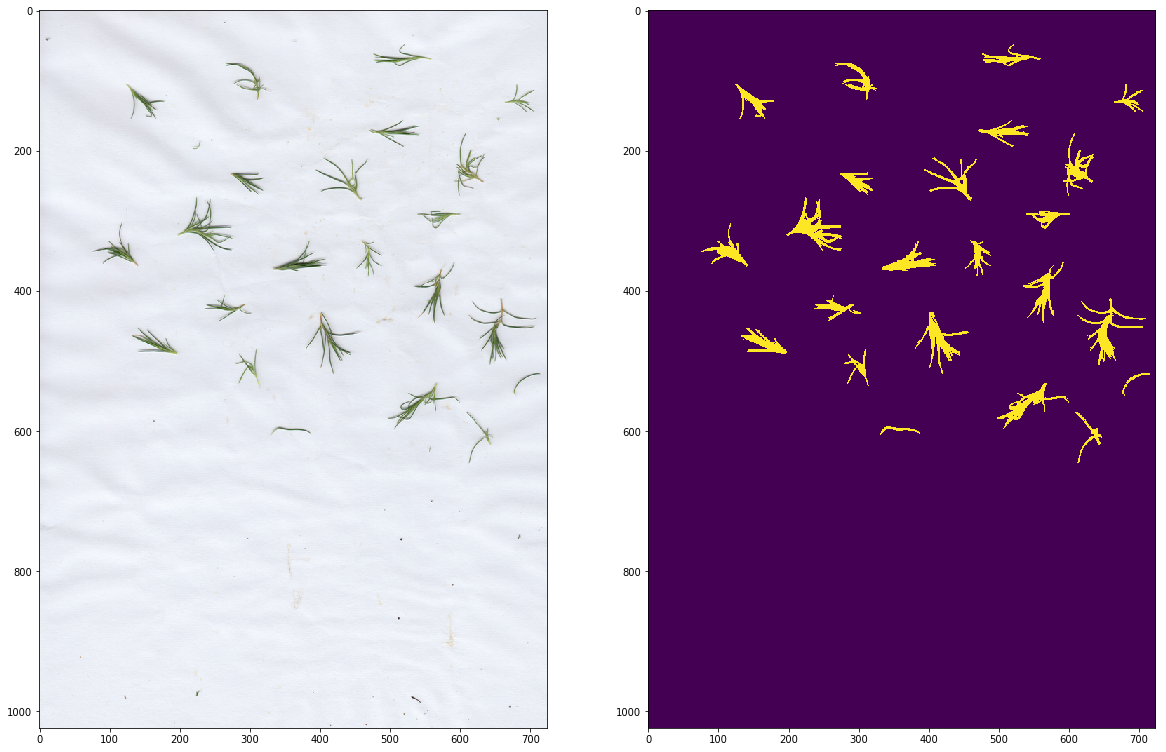

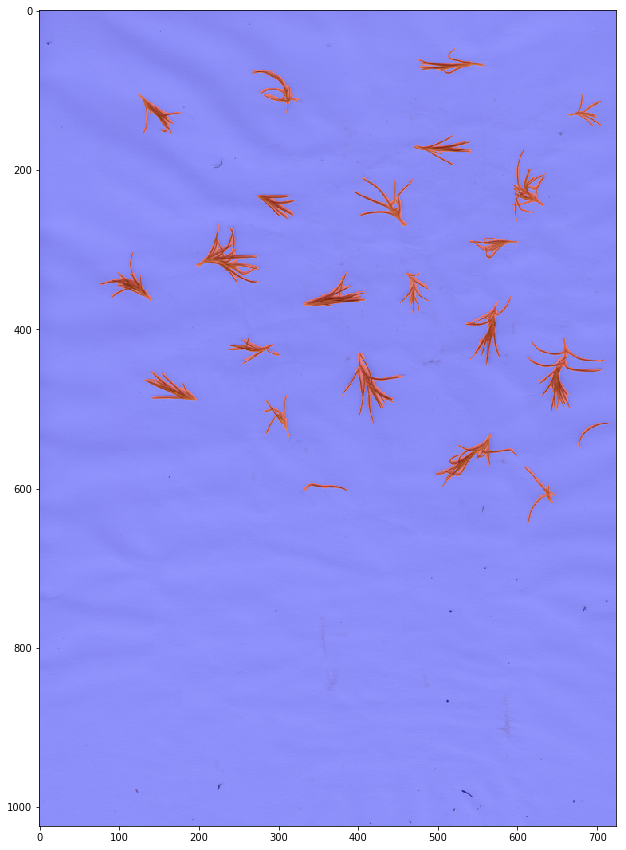

Area: 14.618061639505386 cm²
2/3 Image path /home/mkoerschens/datasets/Scans/Franzi/mini/minuartia_1_benesov_0408.jpg
Image resized by 0.1520415738678545
(1024, 724, 3)
Pixel 720000/741376 (97%)Found component with 818 pixels
Found component with 406 pixels
Found component with 607 pixels
Found component with 1093 pixels
Found component with 929 pixels
Found component with 1007 pixels
Found component with 2016 pixels
Found component with 515 pixels
Found component with 1447 pixels
Found component with 1221 pixels
Found component with 481 pixels
Found component with 192 pixels

Erased 407 components that were too small (< 148.2752 px)


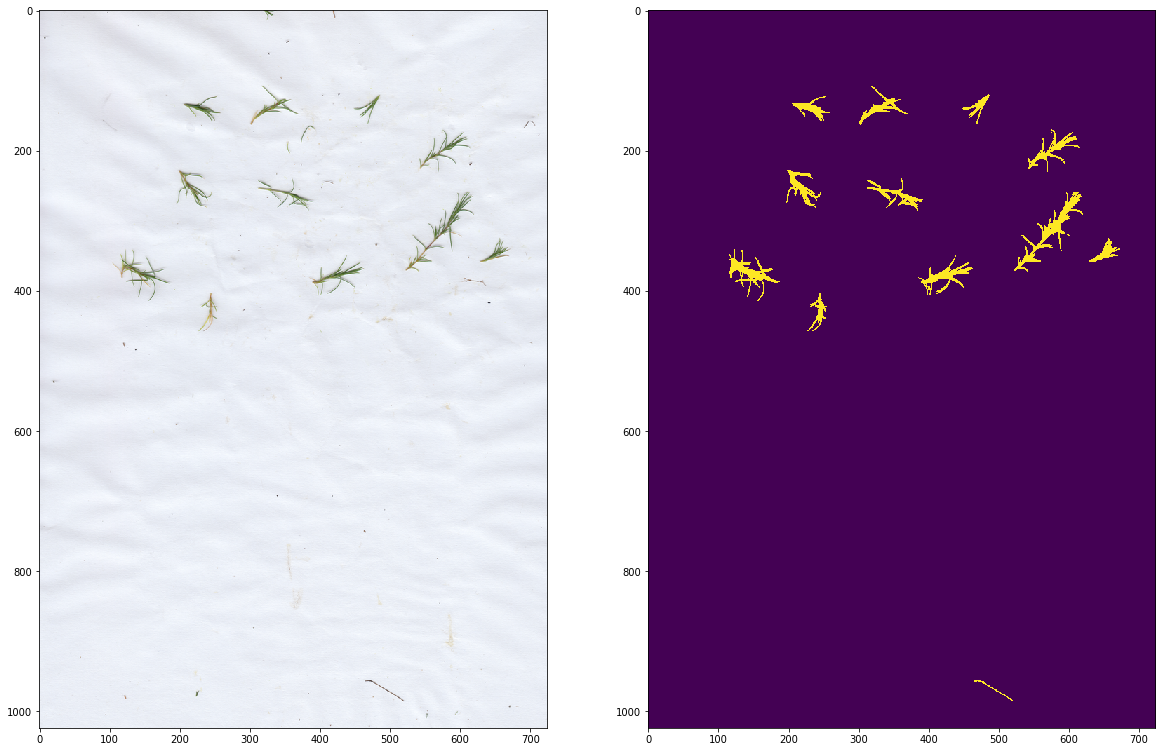

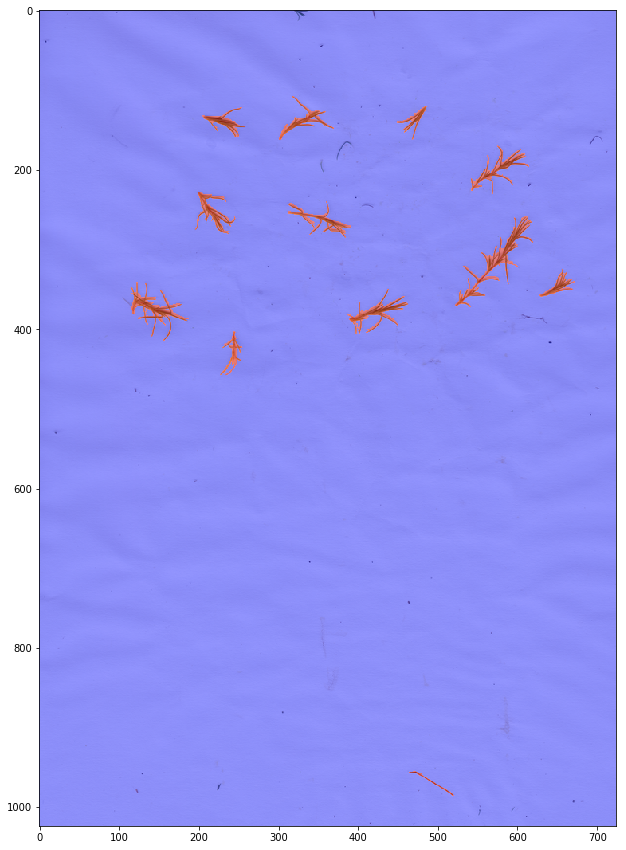

Area: 7.386555542066574 cm²
3/3 Image path /home/mkoerschens/datasets/Scans/Franzi/mini/minuartia_1_bernadice_private_0408.jpg
Image resized by 0.1520415738678545
(1024, 724, 3)
Pixel 720000/741376 (97%)Found component with 681 pixels
Found component with 944 pixels
Found component with 885 pixels
Found component with 614 pixels
Found component with 557 pixels
Found component with 755 pixels
Found component with 698 pixels
Found component with 887 pixels
Found component with 691 pixels
Found component with 176 pixels
Found component with 514 pixels
Found component with 806 pixels
Found component with 734 pixels
Found component with 908 pixels
Found component with 604 pixels
Found component with 892 pixels
Found component with 824 pixels
Found component with 1200 pixels
Found component with 981 pixels
Found component with 1011 pixels
Found component with 1130 pixels
Found component with 1254 pixels

Erased 307 components that were too small (< 148.2752 px)


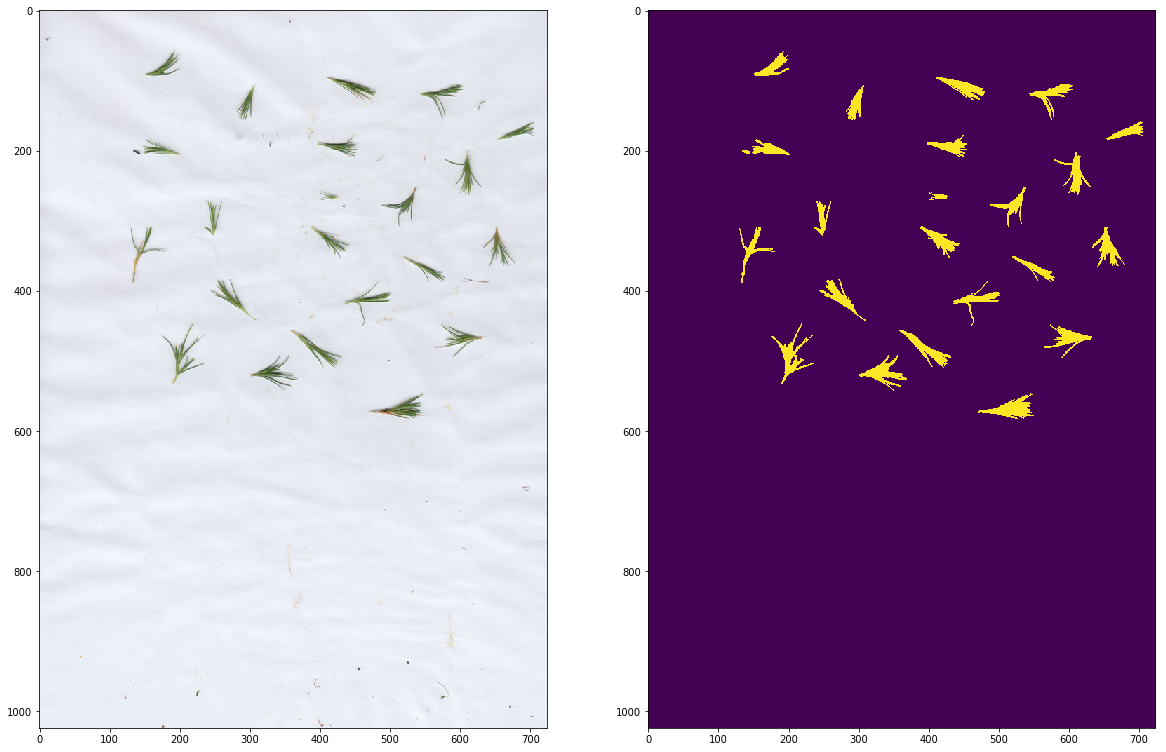

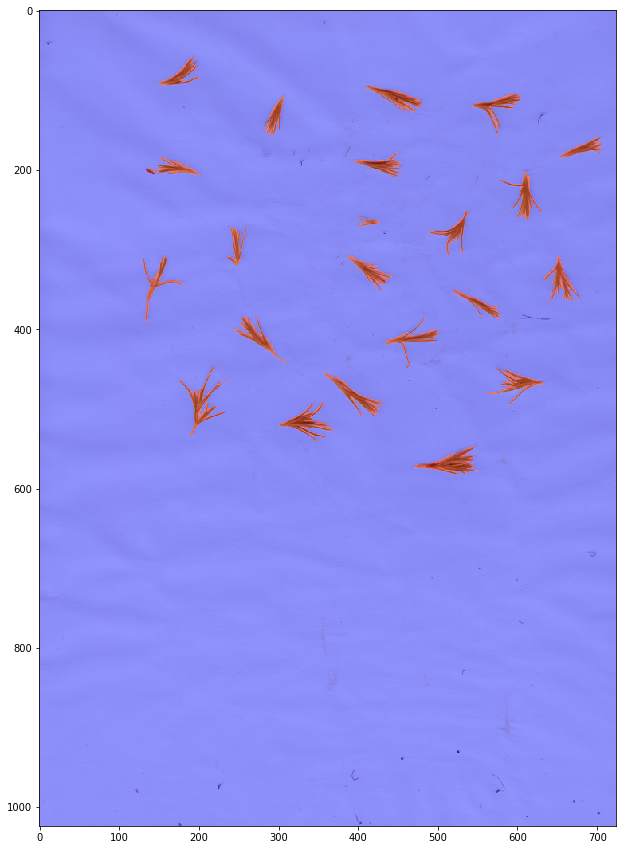

Area: 12.696999020567418 cm²


In [11]:
table_contents = []

table_contents.append([
    "image_name", 
    "area_cm2", 
    "area_mm2", 
    "mean_area_cm2", 
    "mean_area_mm2", 
    "n_components", 
    "image_path"
])

for img_nr, image_path in enumerate(image_paths):
    print(f"{img_nr + 1}/{len(image_paths)} Image path {image_path}")
    
    image = Image.open(image_path).convert("RGB")
    
    if border_crop_relative != 0:
        ary = np.array(image)
        crop_h = int(border_crop_relative * ary.shape[0])
        crop_w = int(border_crop_relative * ary.shape[1])
        # Crop array
        ary = ary[
            crop_h:-crop_h,
            crop_w:-crop_w,
        ]
        image = Image.fromarray(ary)
                          
    old_size = image.size
    
    # Resize image
    new_size = new_image_size(image.size, image_size_bigger_side)
                          
    resize_ratio = max(new_size) / max(old_size)
    
    print("Image resized by", resize_ratio)
    
    dpi_resized = resize_ratio * dpi
    
    image = image.resize(new_size, resample=Image.LANCZOS)
    image = np.array(image)
    
    print(image.shape)
    
    segmentation = floodfill_segmentation(
        image, 
        tolerance=floodfill_tolerance, 
        verbose=True
    )
    segmentation, n_components = erase_small_components(
        segmentation, 
        min_image_percentage=small_component_erase_percentage_threshold
    )
    segmentation = correct_holes(
        image, 
        segmentation
    )
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(segmentation)
    plt.show()
    
    combined = combine_image_and_segmentation(image, segmentation)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(combined)
    plt.show()
                          
    area_cm2 = area_from_segmentation_map(segmentation, dpi_resized)
    
    table_contents.append([
        os.path.basename(image_path), 
        str(area_cm2), 
        str(area_cm2 * 100), 
        str(area_cm2 / n_components), 
        str(area_cm2 * 100 / n_components), 
        str(n_components),
        image_path
    ])
                          
    print(f"Area: {area_cm2} cm²")

In [12]:
if save_path:
    with open(save_path, "w") as f:
        table_rows = [",".join(row_contents) for row_contents in table_contents]
        
        f.write("\n".join(table_rows))
        
df = pd.DataFrame(table_contents[1:], columns=table_contents[0])

df

image_name            area_cm2  \
0       minuartia_1_1_kamberk_13_0308.jpg  14.618061639505386   
1            minuartia_1_benesov_0408.jpg   7.386555542066574   
2  minuartia_1_bernadice_private_0408.jpg  12.696999020567418   

             area_mm2       mean_area_cm2       mean_area_mm2 n_components  \
0  1461.8061639505386  0.6355678973697995   63.55678973697994           23   
1   738.6555542066574  0.6155462951722145   61.55462951722145           12   
2  1269.6999020567418  0.5771363191167008  57.713631911670085           22   

                                          image_path  
0  /home/mkoerschens/datasets/Scans/Franzi/mini/m...  
1  /home/mkoerschens/datasets/Scans/Franzi/mini/m...  
2  /home/mkoerschens/datasets/Scans/Franzi/mini/m...